In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import requests
import json
import glob

In [2]:
candles_df = pd.read_csv('candles.csv')

In [3]:
candles_df.head().to_csv('head.csv')

In [4]:
tokens_count = candles_df['token_symbol'].unique().shape[0]

In [5]:
features = [
    'norm_price_change_candle',
    'norm_volume',
    'norm_buys_usd',
    'norm_buys_count',
    
    'norm_price_change_6h',
    'norm_lh_price_change_6h',
    'norm_volume_6h',
    'norm_buys_usd_6h',
    'norm_buys_count_6h',
    
    'norm_price_change_1d',
    'norm_lh_price_change_1d',
    'norm_volume_1d',
    'norm_buys_usd_1d',
    'norm_buys_count_1d',
    
    'norm_price_change_3d',
    'norm_lh_price_change_3d',
    'norm_volume_3d',
    'norm_buys_usd_3d',
    'norm_buys_count_3d',
    
    'eth_norm_price_change_6h',
    'eth_norm_price_change_candle',
    'eth_norm_volume_6h',
    
    'network_load',
    
    'dom_ratio',

    'k_norm_price_change_candle',
    'k_norm_volume',
    'k_norm_buys_usd',
    'k_norm_buys_count',
    
    'k_norm_price_change_6h',
    'k_norm_lh_price_change_6h',
    'k_norm_volume_6h',
    'k_norm_buys_usd_6h',
    'k_norm_buys_count_6h',
    
    'k_norm_price_change_1d',
    'k_norm_lh_price_change_1d',
    'k_norm_volume_1d',
    'k_norm_buys_usd_1d',
    'k_norm_buys_count_1d',
    
    'k_norm_price_change_3d',
    'k_norm_lh_price_change_3d',
    'k_norm_volume_3d',
    'k_norm_buys_usd_3d',
    'k_norm_buys_count_3d',

    'uni_kucoin_spread',
]

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import MinMaxScaler, StandardScaler

train_split_block_number = 18716744 # 18316744 # Oct-10-2023
test_split_block_number = 18716744 # Dec-05-2023

def split_dataset(X, y):    
    X_train = X[X['open_block_number'] <= train_split_block_number]
    X_train = X_train.drop('open_block_number', axis=1)
    y_train = y[y['open_block_number'] <= train_split_block_number]['target']
    
    X_validation = X[(X['open_block_number'] > train_split_block_number) & ((X['open_block_number'] <= test_split_block_number))]
    X_validation = X_validation.drop('open_block_number', axis=1)
    y_validation = y[(y['open_block_number'] > train_split_block_number) & (y['open_block_number']  <= test_split_block_number)]['target']
    
    X_test = X[X['open_block_number'] > test_split_block_number]
    X_test = X_test.drop('open_block_number', axis=1)
    y_test = y[y['open_block_number'] > test_split_block_number]['target']

    return X_train, y_train, X_validation, y_validation, X_test, y_test

def fit_model(X_train, y_train, X_val, y_val):
    model = CatBoostClassifier(
        early_stopping_rounds=50,    
        auto_class_weights='Balanced',
        loss_function='MultiClass',
        logging_level='Silent',
    )

    grid = {
     'border_count': [128],
     'depth': [6],
     'learning_rate': [0.05],
     'l2_leaf_reg': [3],
     'iterations': [1000]}
    
    grid_search_result = model.grid_search(
                                            grid, 
                                            X=X_train, 
                                            y=y_train, 
                                            # plot=True,
                                            shuffle=False,
                                            verbose=False,
                                        )
    
    return model

In [7]:
X = candles_df[['open_block_number'] + features]
y = candles_df[['open_block_number', 'target']]

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
general_model = fit_model(X_train, y_train, X_val, y_val)

# Метрики

In [8]:
general_model.get_params()

{'loss_function': 'MultiClass',
 'logging_level': 'Silent',
 'auto_class_weights': 'Balanced',
 'early_stopping_rounds': 50,
 'border_count': 128,
 'depth': 6,
 'learning_rate': 0.05,
 'l2_leaf_reg': 3,
 'iterations': 1000}

In [9]:
y_pred = general_model.predict(X_test)
y_proba = general_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.40
Precision: 0.40
Recall: 0.40
F1 Score: 0.40
[[21440 18743 15876]
 [15726 26052 14509]
 [17705 18849 20425]]


In [10]:
y_test.value_counts()

target
 1    56979
 0    56287
-1    56059
Name: count, dtype: int64

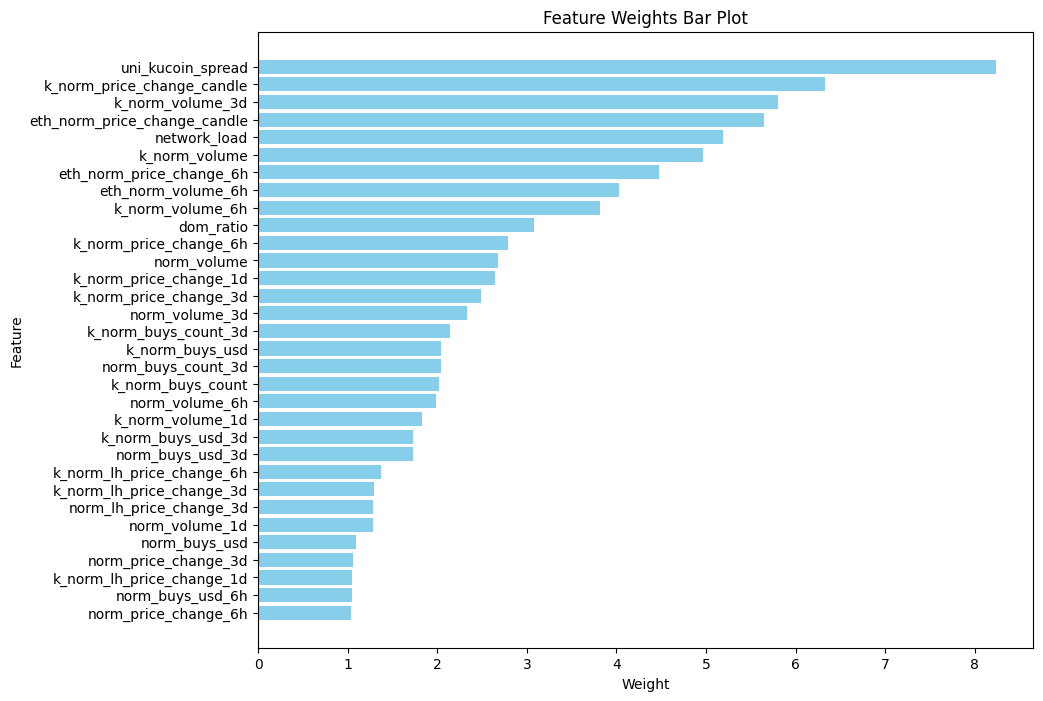

In [11]:
from catboost import Pool
import numpy as np

feature_importances = general_model.get_feature_importance(Pool(X_train, label=y_train))
important_features = np.where(feature_importances > 1)[0]
features_col = X.drop('open_block_number', axis=1).columns[important_features]

weights = feature_importances[important_features]

df = pd.DataFrame({'Feature': features_col, 'Weight': weights})

df_sorted = df.sort_values('Weight', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(df_sorted['Feature'], df_sorted['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Weights Bar Plot')
plt.gca().invert_yaxis()
plt.savefig('fueatures.png')

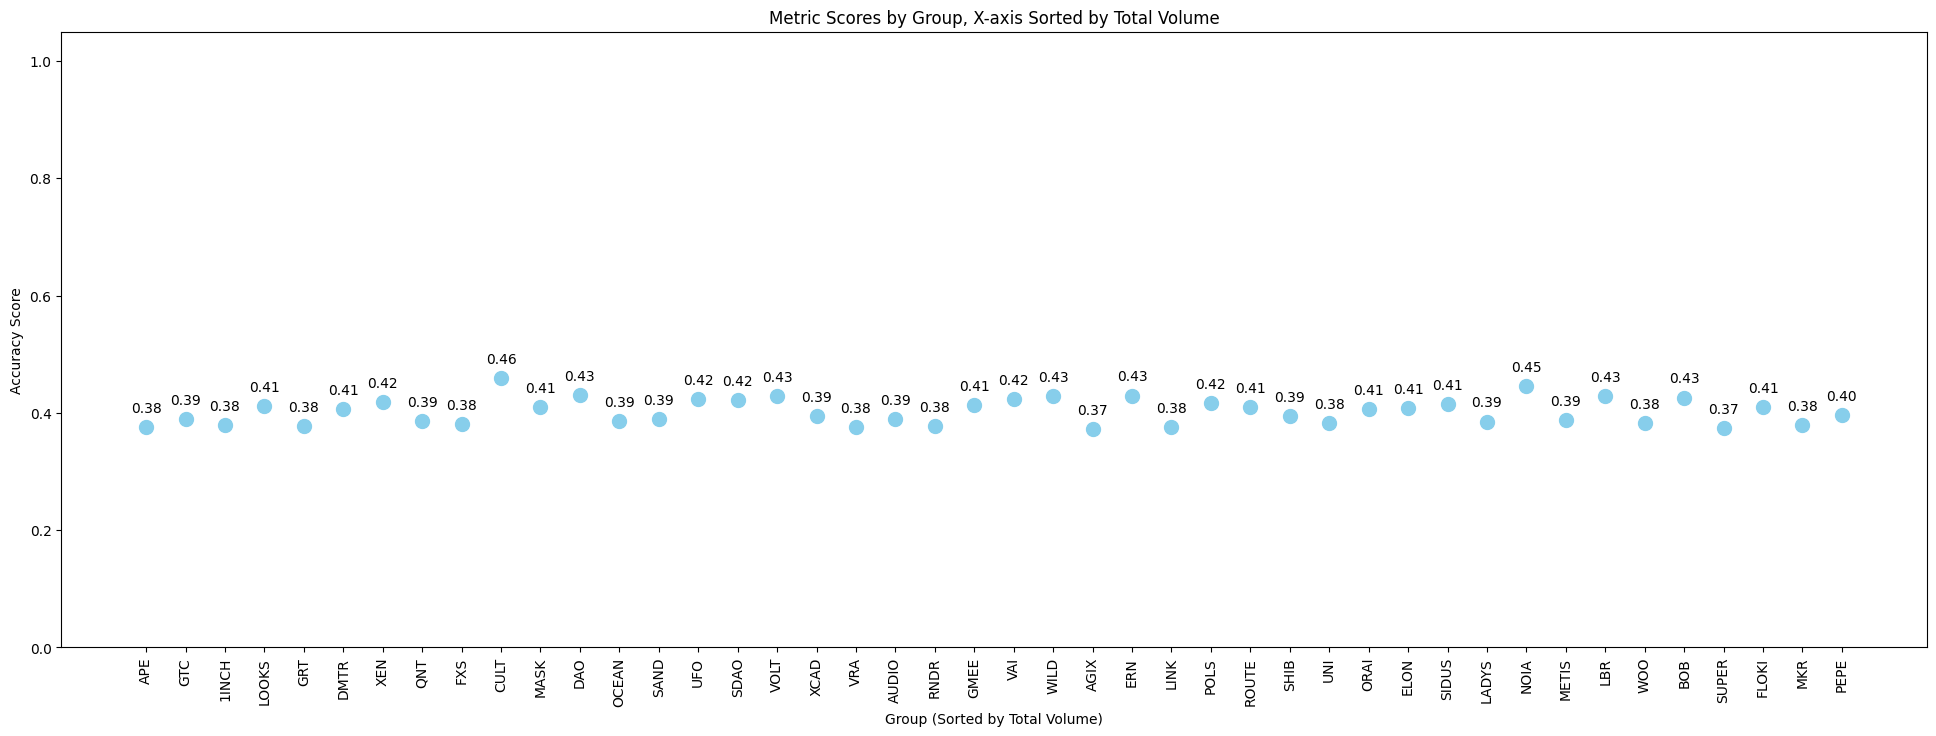

In [12]:
test_dataset = candles_df[candles_df['open_block_number'] > test_split_block_number]
grouped = test_dataset.groupby('token_symbol')

metric_scores = {}

for name, group in grouped:
    X_test = group[features]
    y_true = group['target']
    
    y_pred = general_model.predict(X_test)
    
    score = accuracy_score(y_true, y_pred)
    metric_scores[name] = score

group_volumes = test_dataset.groupby('token_symbol')['volume'].sum()

sorted_groups = group_volumes.sort_values().index.tolist()

sorted_scores = [metric_scores.get(group, np.nan) for group in sorted_groups]

final_groups = [group for group, score in zip(sorted_groups, sorted_scores) if not np.isnan(score)]
final_scores = [score for score in sorted_scores if not np.isnan(score)]

x_pos = np.arange(len(final_groups))

plt.figure(figsize=(20, 8))
plt.scatter(x_pos, final_scores, color='skyblue', s=100)

plt.xticks(x_pos, final_groups, rotation=90, ha='center')
plt.xlabel('Group (Sorted by Total Volume)')
plt.ylabel('Accuracy Score')
plt.title('Metric Scores by Group, X-axis Sorted by Total Volume')
plt.ylim(0, 1.05)

for i, score in enumerate(final_scores):
    plt.text(x_pos[i], score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout(pad=3.0)
plt.savefig('tokens.png')

# Модель на фичах univ2

In [13]:
univ2_features = [
    'norm_price_change_candle',
    'norm_volume',
    'norm_buys_usd',
    'norm_buys_count',
    
    'norm_price_change_6h',
    'norm_lh_price_change_6h',
    'norm_volume_6h',
    'norm_buys_usd_6h',
    'norm_buys_count_6h',
    
    'norm_price_change_1d',
    'norm_lh_price_change_1d',
    'norm_volume_1d',
    'norm_buys_usd_1d',
    'norm_buys_count_1d',
    
    'norm_price_change_3d',
    'norm_lh_price_change_3d',
    'norm_volume_3d',
    'norm_buys_usd_3d',
    'norm_buys_count_3d',
    
    'eth_norm_price_change_6h',
    'eth_norm_price_change_candle',
    'eth_norm_volume_6h',
    
    'network_load',
    
    'dom_ratio',
]

In [14]:
X = candles_df[['open_block_number'] + univ2_features]
y = candles_df[['open_block_number', 'target']]

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
univ2_model = fit_model(X_train, y_train, X_val, y_val)

In [15]:
y_pred = univ2_model.predict(X_test)
y_proba = univ2_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.37
Precision: 0.37
Recall: 0.37
F1 Score: 0.37
[[18420 21240 16399]
 [15126 27285 13876]
 [18116 21169 17694]]


# Модель на Kucoin фичах

In [16]:
kucoin_features = [
    'k_norm_price_change_candle',
    'k_norm_volume',
    'k_norm_buys_usd',
    'k_norm_buys_count',
    
    'k_norm_price_change_6h',
    'k_norm_lh_price_change_6h',
    'k_norm_volume_6h',
    'k_norm_buys_usd_6h',
    'k_norm_buys_count_6h',
    
    'k_norm_price_change_1d',
    'k_norm_lh_price_change_1d',
    'k_norm_volume_1d',
    'k_norm_buys_usd_1d',
    'k_norm_buys_count_1d',
    
    'k_norm_price_change_3d',
    'k_norm_lh_price_change_3d',
    'k_norm_volume_3d',
    'k_norm_buys_usd_3d',
    'k_norm_buys_count_3d',
]

In [17]:
X = candles_df[['open_block_number'] + kucoin_features]
y = candles_df[['open_block_number', 'target']]

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
kucoin_model = fit_model(X_train, y_train, X_val, y_val)

In [18]:
y_pred = kucoin_model.predict(X_test)
y_proba = kucoin_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.39
Precision: 0.39
Recall: 0.39
F1 Score: 0.39
[[20303 20897 14859]
 [14915 28174 13198]
 [17695 21042 18242]]


# Индивидуальные модели

In [19]:
models = {}
for name, group in candles_df.groupby('token_symbol'):    
    X = group[['open_block_number'] + features]
    y = group[['open_block_number', 'target']]

    X_train, y_train, X_validation, y_validation, _, _ = split_dataset(X, y)
    
    model = fit_model(X_train, y_train, X_validation, y_validation)

    models[name] = model

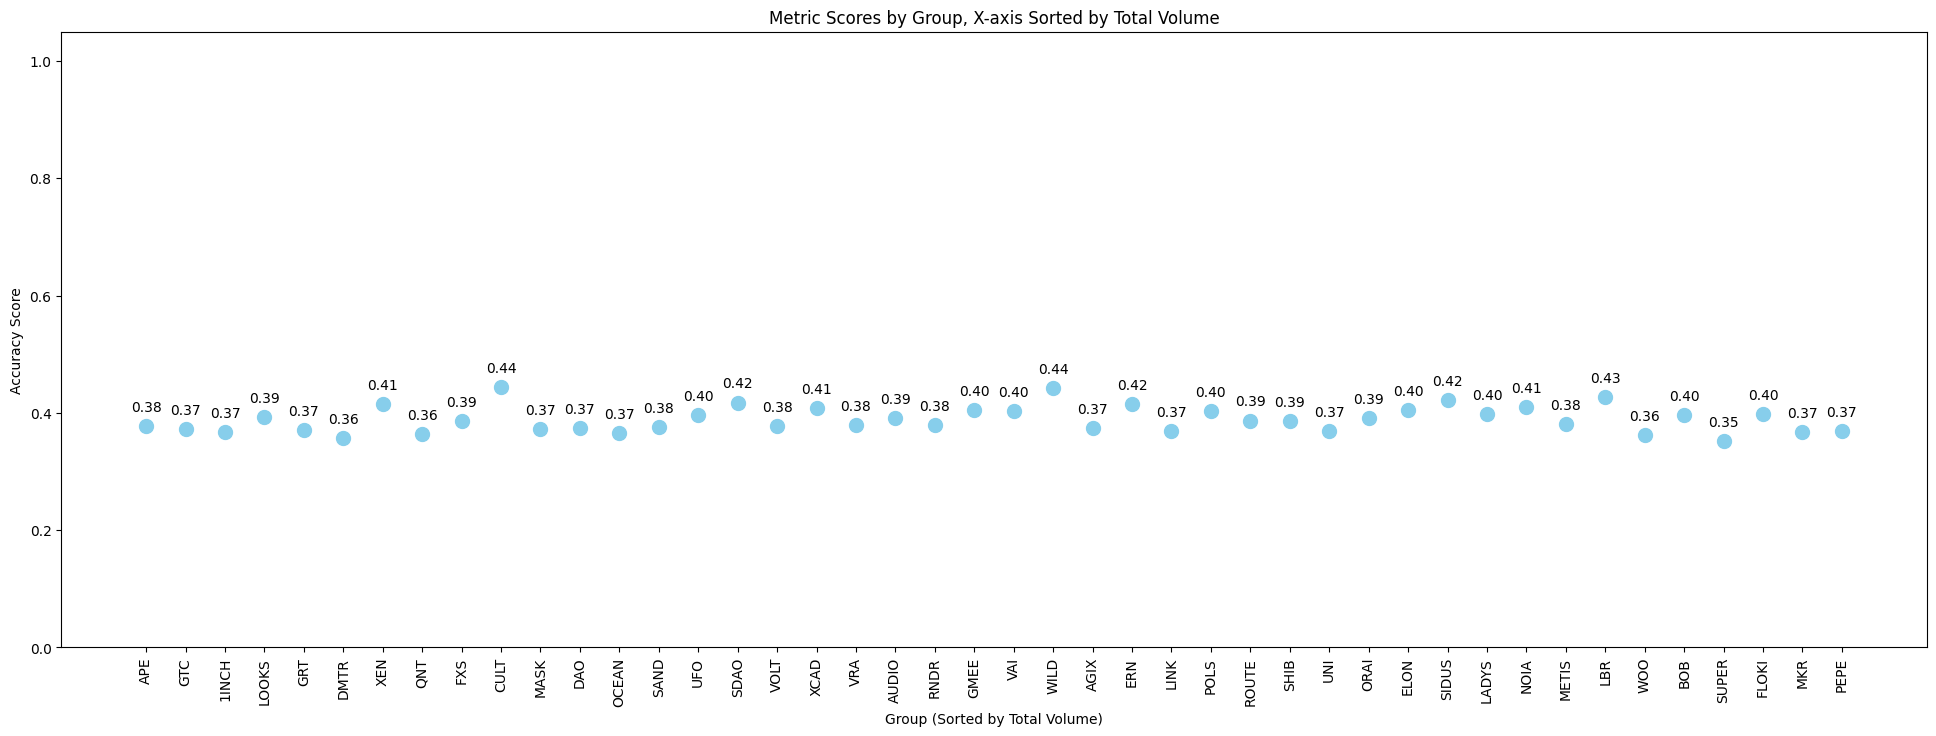

In [20]:
test_dataset = candles_df[candles_df['token_symbol'].isin(models.keys())]
test_dataset = test_dataset[test_dataset['open_block_number'] > test_split_block_number]
grouped = test_dataset.groupby('token_symbol')

metric_scores = {}

for name, group in grouped:
    if name not in models:
        continue
    
    X_test = group[features]
    y_true = group['target']

    model = models[name]
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_true, y_pred)
    metric_scores[name] = score

group_volumes = test_dataset.groupby('token_symbol')['volume'].sum()

sorted_groups = group_volumes.sort_values().index.tolist()

sorted_scores = [metric_scores.get(group, np.nan) for group in sorted_groups]

final_groups = [group for group, score in zip(sorted_groups, sorted_scores) if not np.isnan(score)]
final_scores = [score for score in sorted_scores if not np.isnan(score)]

x_pos = np.arange(len(final_groups))

plt.figure(figsize=(20, 8))
plt.scatter(x_pos, final_scores, color='skyblue', s=100)

plt.xticks(x_pos, final_groups, rotation=90, ha='center')
plt.xlabel('Group (Sorted by Total Volume)')
plt.ylabel('Accuracy Score')
plt.title('Metric Scores by Group, X-axis Sorted by Total Volume')
plt.ylim(0, 1.05)

for i, score in enumerate(final_scores):
    plt.text(x_pos[i], score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout(pad=3.0)
plt.savefig('individual.png')

# Бэктест

In [21]:
def show_sharpes(test_dataset, profit_label):
    sharpes = {}
    
    for name, group in test_dataset.groupby('token_symbol'):
        backtest_df = group.groupby('timestamp')[profit_label].sum() / tokens_count
    
        yearly = backtest_df.mean() * 24 * 3 * 365
        std = backtest_df.std() * (24 * 3 * 365) ** 0.5
     
        sharpes[name] = yearly / std
    
    
    group_volumes = test_dataset.groupby('token_symbol')['volume'].sum()
    
    sorted_groups = group_volumes.sort_values().index.tolist()
    
    sorted_scores = [sharpes.get(group, np.nan) for group in sorted_groups]
    
    final_groups = [group for group, score in zip(sorted_groups, sorted_scores) if not np.isnan(score)]
    final_scores = [score for score in sorted_scores if not np.isnan(score)]
    
    x_pos = np.arange(len(final_groups))
    
    plt.figure(figsize=(20, 8))
    plt.scatter(x_pos, final_scores, color='skyblue', s=100)
    
    plt.xticks(x_pos, final_groups, rotation=90, ha='center')
    plt.xlabel('Group (Sorted by Total Volume)')
    plt.ylabel('Sharpe')
    plt.title('Metric Scores by Group, X-axis Sorted by Total Volume')
    plt.ylim(0, 40)
    
    for i, score in enumerate(final_scores):
        plt.text(x_pos[i], score + 0.02, f'{score:.2f}', ha='center', va='bottom')
    
    plt.tight_layout(pad=3.0)
    plt.savefig(f'sharpe_{profit_label}.png')

In [22]:
strategy_metrics_list = []

def add_strategy_metrics(strategy_name, annual_return, volatility, sharpe, profits):
    strategy_metrics_list.append({
        'Strategy': strategy_name,
        'Annual return': annual_return,
        'Volatility': volatility,
        'Sharpe': sharpe,
        'Profits': profits
    })

Общая модель

In [23]:
fee = 0.0002 # 0.0006

test_df = candles_df[candles_df['open_block_number'] > test_split_block_number].copy()
test_df['prediction'] = general_model.predict(test_df[features])
test_df['profit'] = (test_df['k_target_price'] / test_df['k_close'] - 1) * test_df['prediction']
test_df['profit_net'] = test_df['profit'] - fee
test_df['fut_ret_raw'] = (test_df['k_target_price'] / test_df['k_close'] - 1)

backtest_df = test_df.groupby('timestamp')['profit_net'].sum() / tokens_count

annual_return = backtest_df.mean() * 24 * 3 * 365
volatility = backtest_df.std() * (24 * 3 * 365) ** 0.5
sharpe = (backtest_df.mean() * 24 * 3 * 365) / (backtest_df.std() * (24 * 3 * 365) ** 0.5)
deals_percent = test_df[test_df['prediction'] != 0].shape[0] / (24 * 3 * 105 * tokens_count)

print(f'Deals percent: {deals_percent}')

add_strategy_metrics('General model', annual_return, volatility, sharpe, backtest_df.cumsum())

Deals percent: 0.31770382395382396


Модель на фичах univ2

In [24]:
test_df['univ2_prediction'] = univ2_model.predict(test_df[univ2_features])
test_df['univ2_profit'] = (test_df['k_target_price'] / test_df['k_close'] - 1) * test_df['univ2_prediction']

backtest_df = test_df.groupby('timestamp')['univ2_profit'].sum() / tokens_count

annual_return = backtest_df.mean() * 24 * 3 * 365
volatility = backtest_df.std() * (24 * 3 * 365) ** 0.5
sharpe = (backtest_df.mean() * 24 * 3 * 365) / (backtest_df.std() * (24 * 3 * 365) ** 0.5)
deals_percent = test_df[test_df['univ2_prediction'] != 0].shape[0] / (24 * 3 * 105 * tokens_count)

print(f'Deals percent: {deals_percent}')

add_strategy_metrics('UniV2 model', annual_return, volatility, sharpe, backtest_df.cumsum())

Deals percent: 0.29951599326599326


Модель на фичах Kucin

In [25]:
test_df['kucoin_prediction'] = kucoin_model.predict(test_df[kucoin_features])
test_df['kucoin_profit'] = (test_df['k_target_price'] / test_df['k_close'] - 1) * test_df['kucoin_prediction']

backtest_df = test_df.groupby('timestamp')['kucoin_profit'].sum() / tokens_count

annual_return = backtest_df.mean() * 24 * 3 * 365
volatility = backtest_df.std() * (24 * 3 * 365) ** 0.5
sharpe = (backtest_df.mean() * 24 * 3 * 365) / (backtest_df.std() * (24 * 3 * 365) ** 0.5)
deals_percent = test_df[test_df['kucoin_prediction'] != 0].shape[0] / (24 * 3 * 105 * tokens_count)

print(f'Deals percent: {deals_percent}')

add_strategy_metrics('Kucoin model', annual_return, volatility, sharpe, backtest_df.cumsum())

Deals percent: 0.2982563732563733


Индивидуальные модели

In [26]:
def calculate(group):
    model = models[group.name]
        
    group['ind_prediction'] = model.predict(group[features])
    group['ind_profit'] = (group['k_target_price'] / group['k_close'] - 1) * group['ind_prediction']
    
    return group

test_df = test_df.groupby('token_symbol').apply(calculate).reset_index(drop=True).drop(columns=['Unnamed: 0'], axis=1)

backtest_df = test_df.groupby('timestamp')['ind_profit'].sum() / tokens_count

annual_return = backtest_df.mean() * 24 * 3 * 365
volatility = backtest_df.std() * (24 * 3 * 365) ** 0.5
sharpe = (backtest_df.mean() * 24 * 3 * 365) / (backtest_df.std() * (24 * 3 * 365) ** 0.5)
deals_percent = test_df[test_df['ind_prediction'] != 0].shape[0] / (24 * 3 * 105 * tokens_count)

print(f'Deals percent: {deals_percent}')

add_strategy_metrics('Individual models', annual_return, volatility, sharpe, backtest_df.cumsum())

/tmp/ipykernel_1063586/3343295528.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby('token_symbol').apply(calculate).reset_index(drop=True).drop(columns=['Unnamed: 0'], axis=1)


Deals percent: 0.34524410774410774


Hold стратегия

In [27]:
test_df['hold_profit'] = test_df['k_close'] / test_df['k_open'] - 1

backtest_df = test_df.groupby('timestamp')['hold_profit'].sum() / tokens_count

annual_return = backtest_df.mean() * 24 * 3 * 365
volatility = backtest_df.std() * (24 * 3 * 365) ** 0.5
sharpe = (backtest_df.mean() * 24 * 3 * 365) / (backtest_df.std() * (24 * 3 * 365) ** 0.5)

add_strategy_metrics('Hold', annual_return, volatility, sharpe, backtest_df.cumsum())

Moving average

In [28]:
test_df['moving_average'] = test_df['k_close'].rolling(window=3 * 24).mean()

test_df.loc[test_df['k_close'] * (1 - test_df['k_std_price_changes_6h']) > test_df['moving_average'], 'signal'] = -1
test_df.loc[test_df['k_close'] * (1 + test_df['k_std_price_changes_6h']) < test_df['moving_average'], 'signal'] = 1

test_df['moving_average_profit'] = 0.0
test_df.loc[test_df['signal'] == 1, 'moving_average_profit'] = test_df['k_target_price'] / test_df['k_close'] - 1

backtest_df = test_df.groupby('timestamp')['moving_average_profit'].sum() / tokens_count
    
annual_return = backtest_df.mean() * 24 * 3 * 365
volatility = backtest_df.std() * (24 * 3 * 365) ** 0.5
sharpe = (backtest_df.mean() * 24 * 3 * 365) / (backtest_df.std() * (24 * 3 * 365) ** 0.5)

add_strategy_metrics('Moving average', annual_return, volatility, sharpe, backtest_df.cumsum())

In [29]:
df_metrics = pd.DataFrame(strategy_metrics_list)
df_metrics.to_csv('profits.csv')

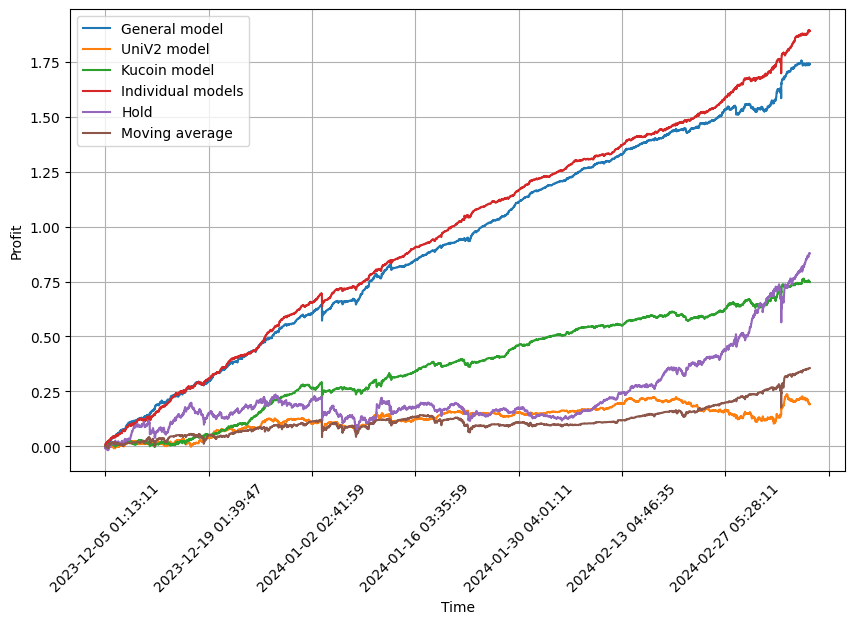

In [30]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

for idx, row in df_metrics.iterrows():
    row['Profits'].plot(ax=plt.gca(), label=row['Strategy'])

plt.xticks(rotation=45)

plt.xlabel('Time')
plt.ylabel('Profit')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('profits.png')

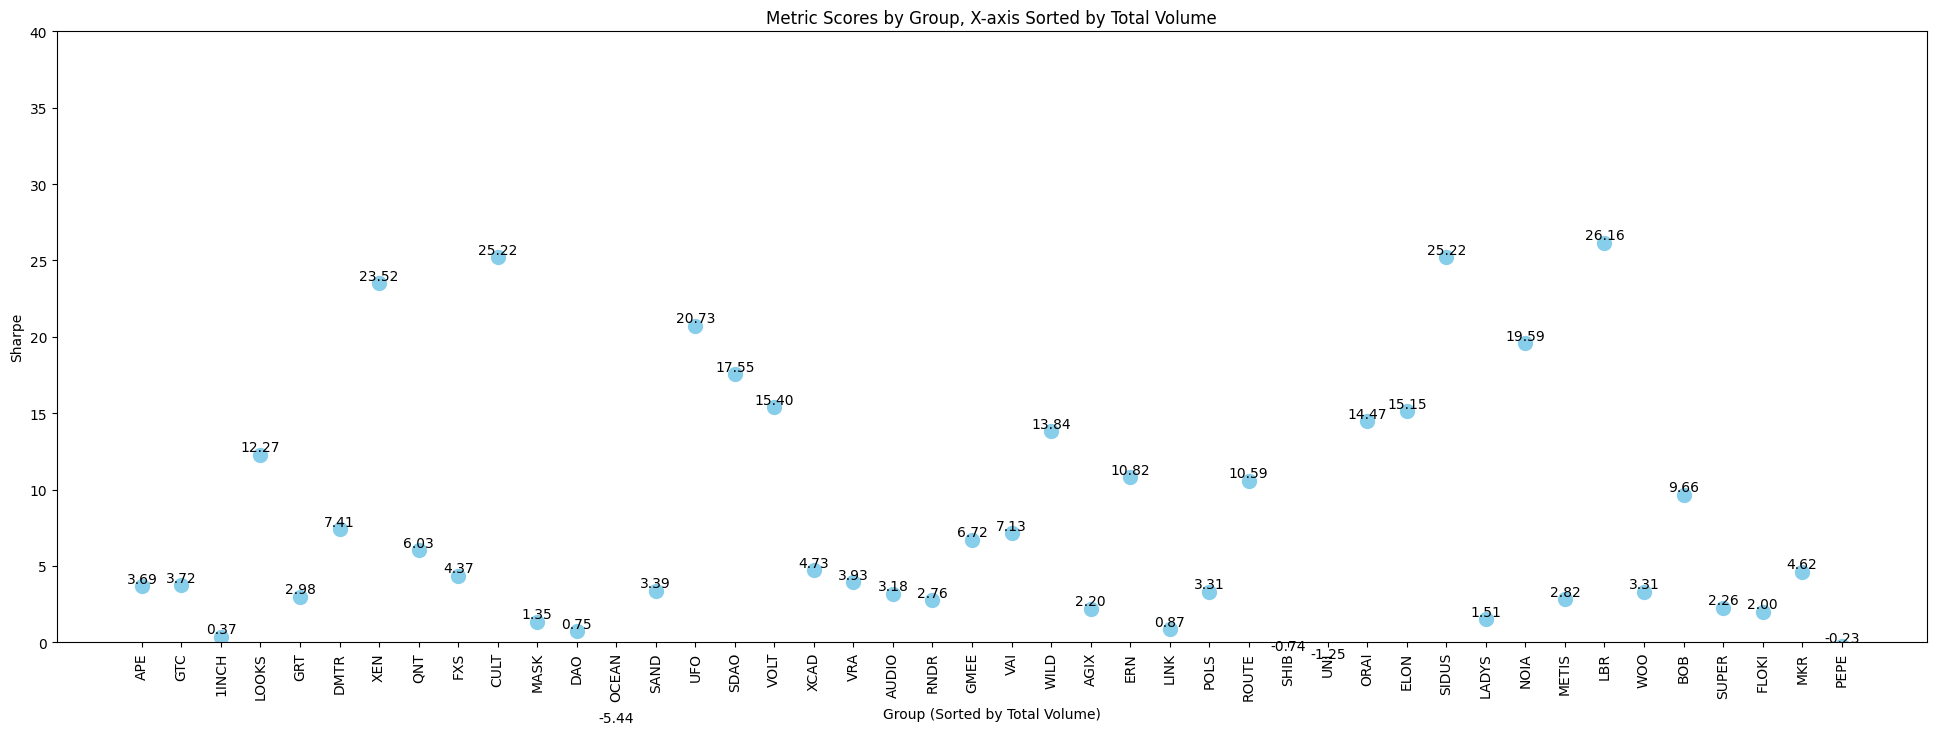

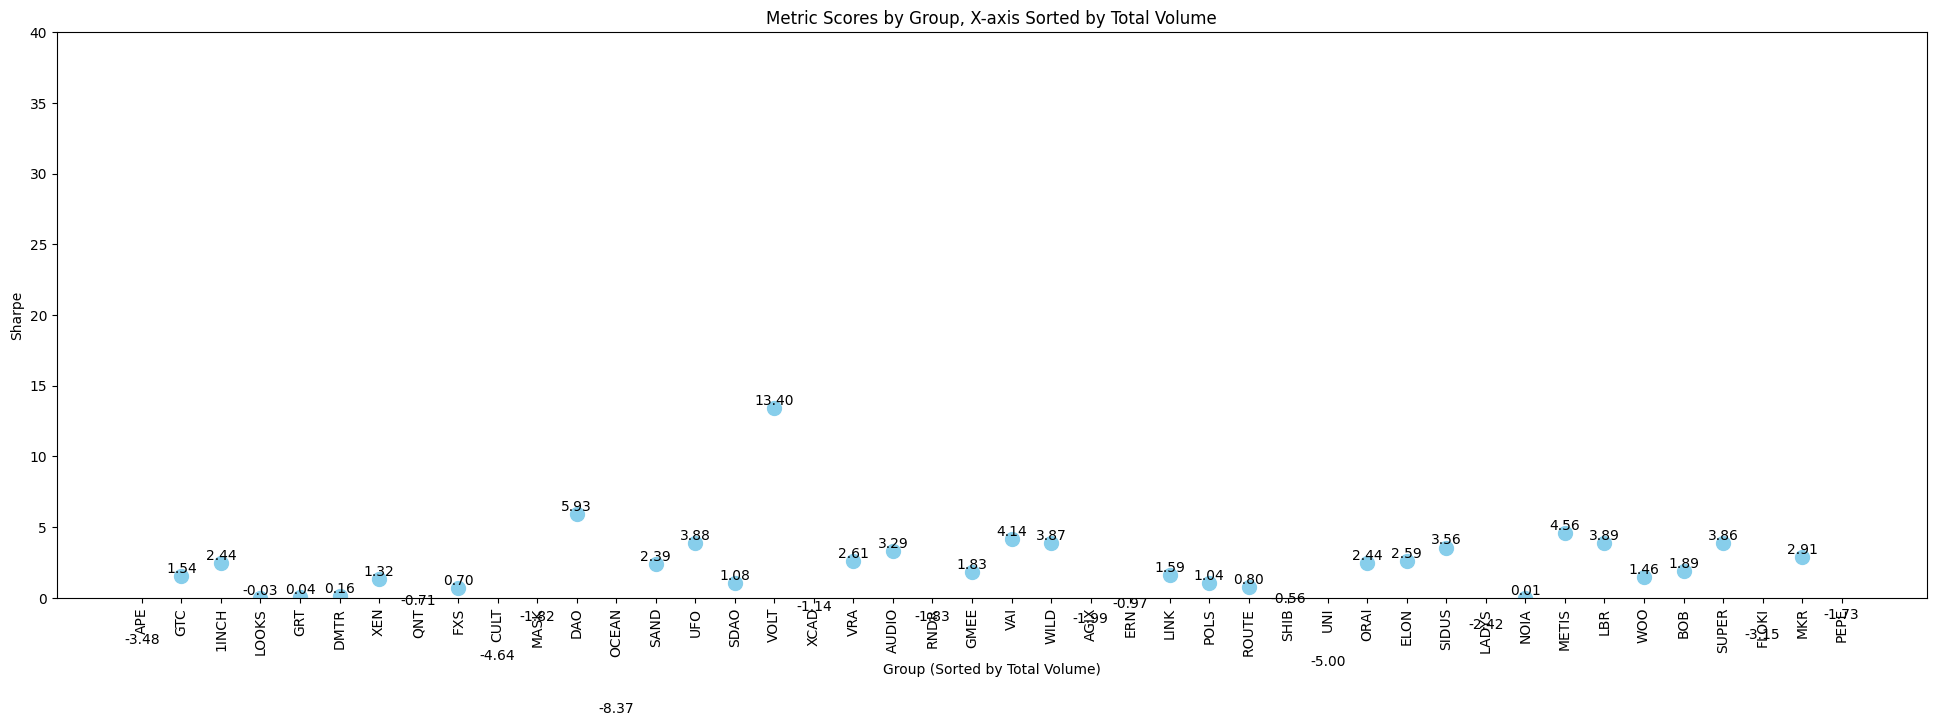

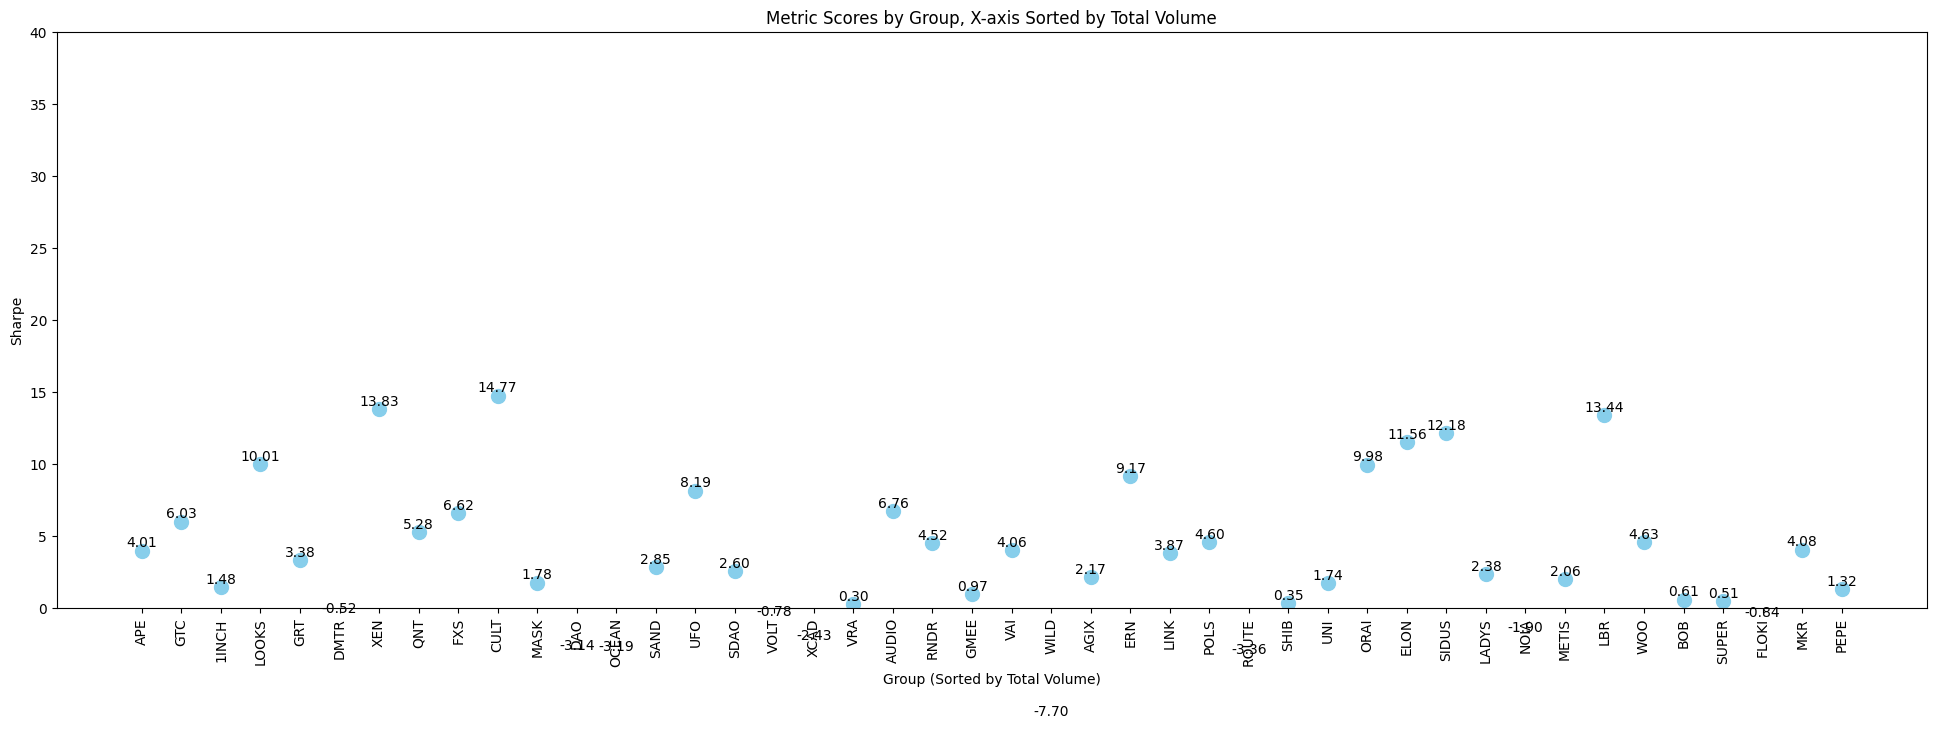

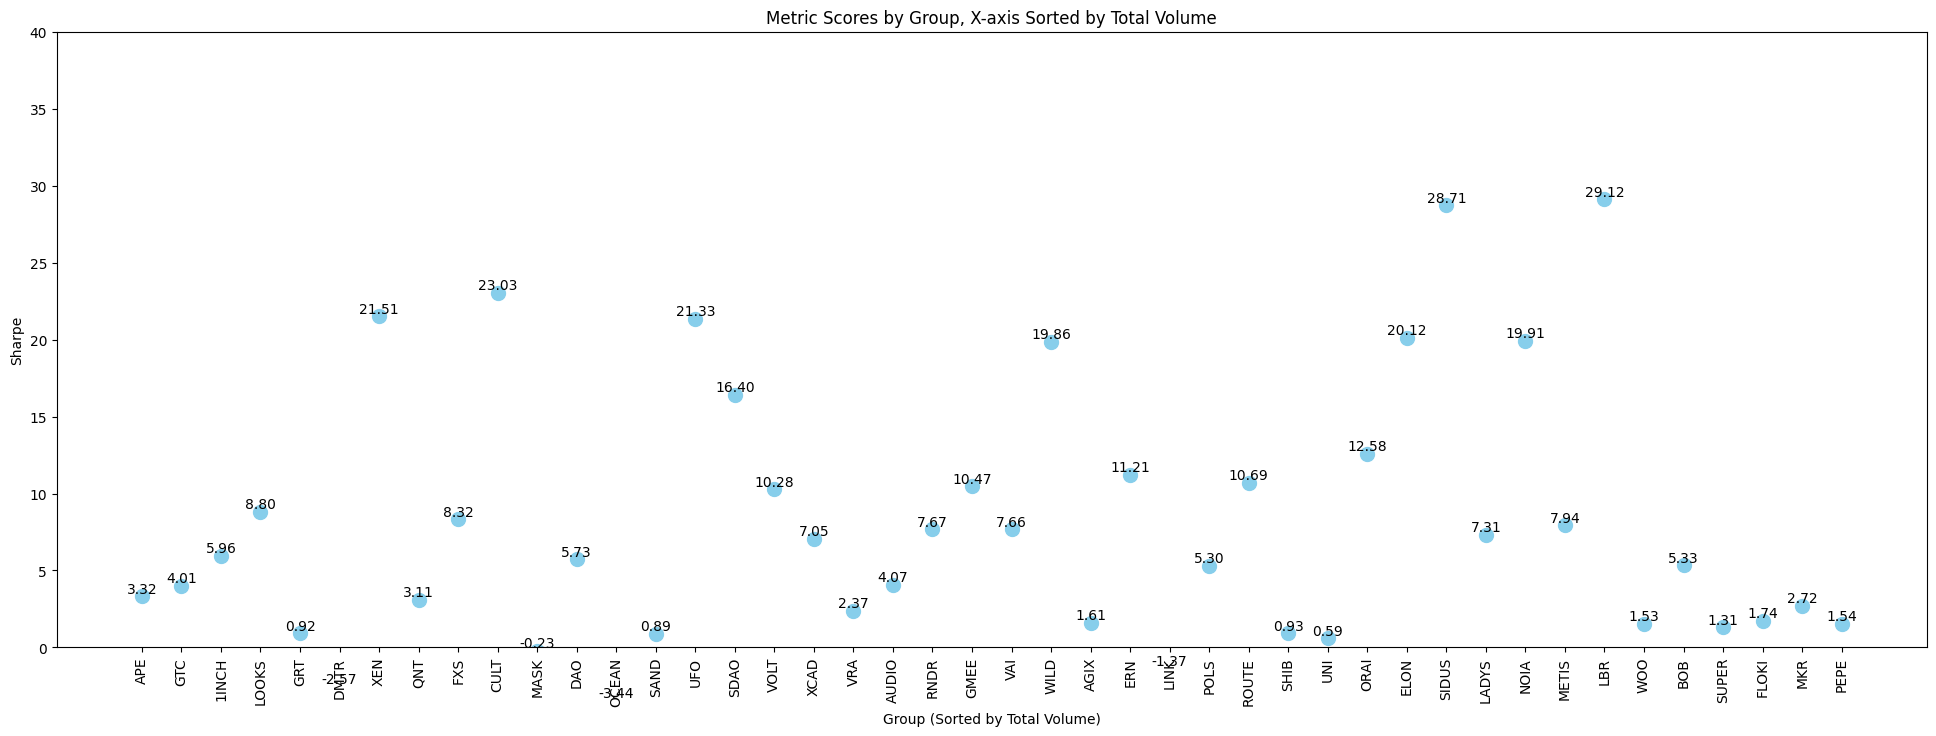

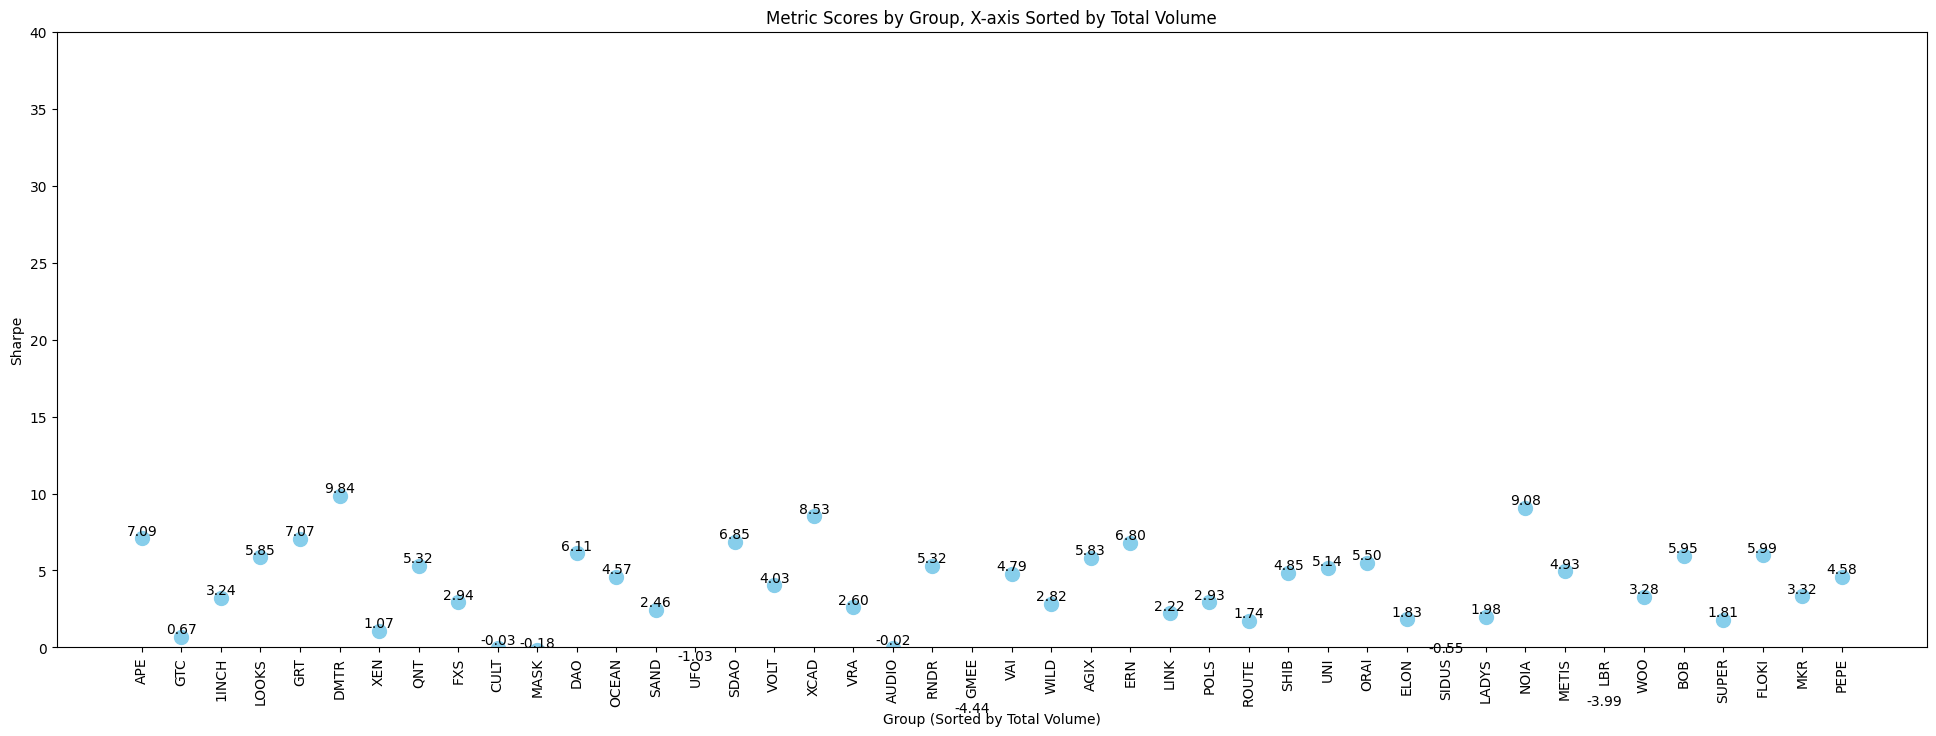

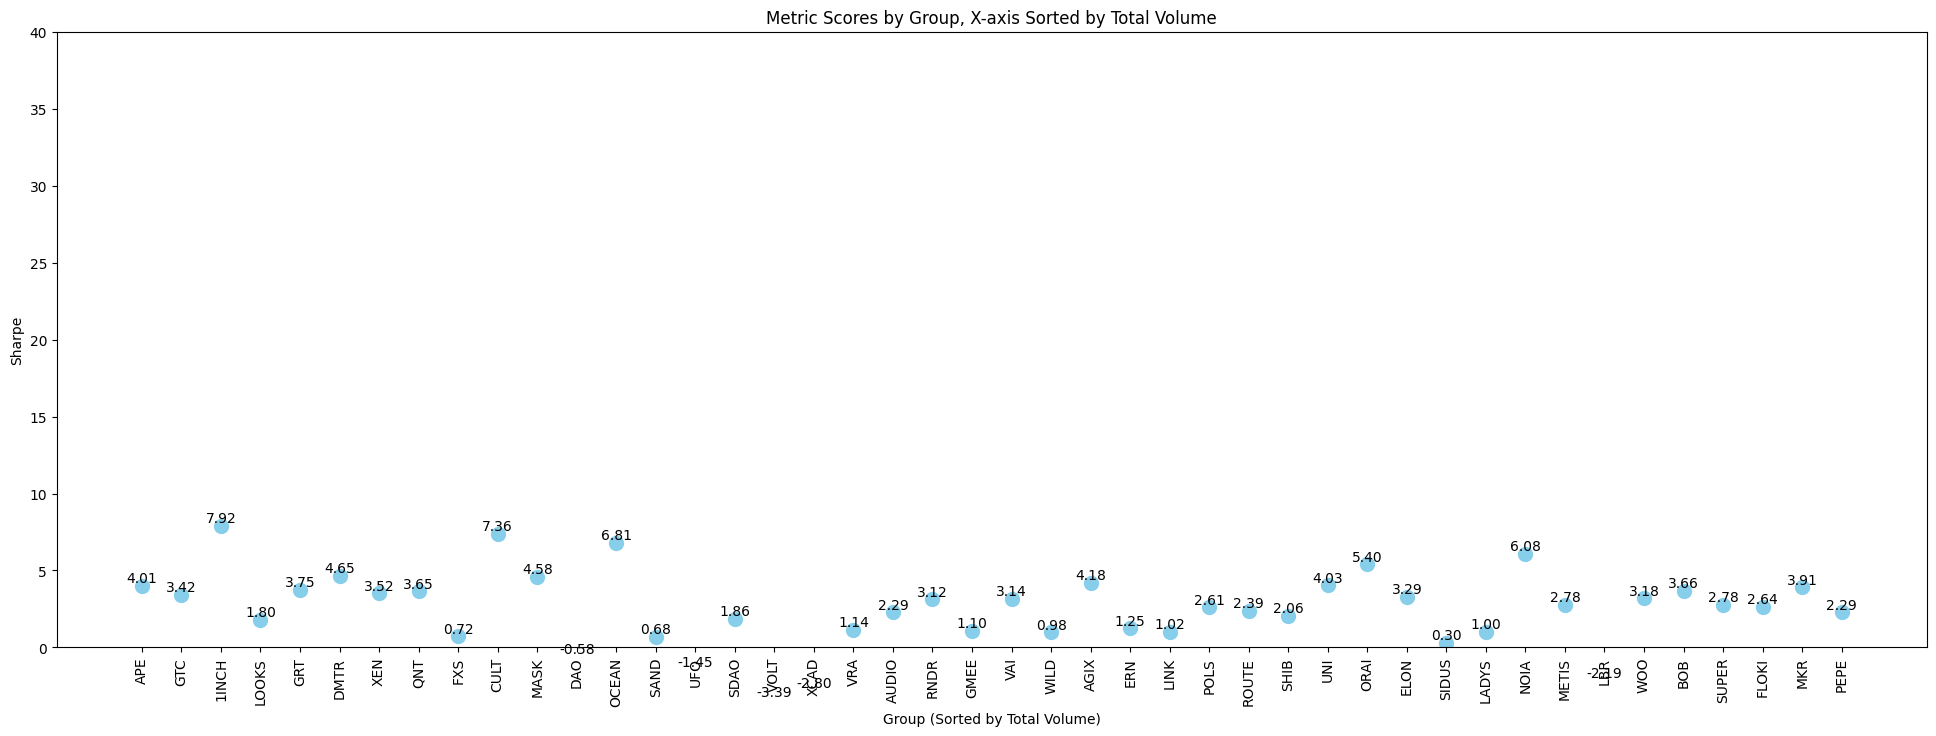

In [31]:
show_sharpes(test_df, 'profit')
show_sharpes(test_df, 'univ2_profit')
show_sharpes(test_df, 'kucoin_profit')
show_sharpes(test_df, 'ind_profit')
show_sharpes(test_df, 'hold_profit')
show_sharpes(test_df, 'moving_average_profit')